<a href="https://colab.research.google.com/github/faisal-ba-systems/ML-course-documents/blob/main/EDA_Project_Cost_Estimation_Business_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns

In [321]:
!pip install -q gdown

# https://docs.google.com/spreadsheets/d/1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ/edit?usp=sharing

!gdown 1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ

Downloading...
From (original): https://drive.google.com/uc?id=1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ
From (redirected): https://docs.google.com/spreadsheets/d/1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ/export?format=xlsx
To: /content/Project Milestone wise log for 24 months 07082025.xlsx
6.25MB [00:01, 4.54MB/s]


In [322]:
excel_path ='/content/Project Milestone wise log for 24 months 07082025.xlsx'
sheet_milestone_resource = 'Milestone Details'
sheet_projects = 'Projects'
sheet_log_hour_against_issue = 'Log Details'
df_milestone_resource = pd.read_excel(excel_path, sheet_name=sheet_milestone_resource)
df_projects = pd.read_excel(excel_path, sheet_name=sheet_projects)
df_log_hour_issue = pd.read_excel(excel_path, sheet_name=sheet_log_hour_against_issue)

In [323]:
def report_data_types_uniques_check(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []

    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [324]:
# report_data_types_uniques_check(df_projects)
report_data_types_uniques_check(df_milestone_resource)
# report_data_types_uniques_check(df_log_hour_issue)

,Column,d_type,unique_sample,n_uniques
0,Milestone,object,"[Support & Maintenance, Development, nan, Supp...",1251
1,start_dt,datetime64[ns],"[2025-05-01 00:00:00, NaT, 2018-09-16 00:00:00...",462
2,end_dt,datetime64[ns],"[2026-05-31 00:00:00, NaT, 2024-08-31 00:00:00...",424
3,Project,object,[e-Hajj Management System (MoRA/e-HMSB/HAJ-202...,338
4,ProjectCategory,object,"[Commercial, Others, Non-Commercial]",3
5,ResourceList,object,[Mohammad Ashrafuzzaman (ashraf@ba-systems.co...,824
6,TotalHour,float64,"[37209.35, 29076.18, 25183.78, 16773.83, 15969...",485


### Analysis Dataset

In [325]:
batch_color_discrete_map={
                'complete': 'green',
                'ongoing': 'gold',
                'upcoming': 'lightgreen',
                 }

project_category_color_discrete_map={
                'Commercial': 'green',
                'Non-Commercial': 'blue',
                'Others': 'red'
              }



# Section 1 - Analysis Project Overview - Timeline: 2001 - 2025

### Clean & Preprocess

In [326]:
# Safe conversion: invalid dates like '0000-00-00' will become NaT
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')
# Calculate duration in days (NaT-safe)
df_projects['duration_days'] = (df_projects['end_dt'] - df_projects['start_dt']).dt.days
# Format as 'YYYY-MM-DD'
df_projects['start_dt'] = df_projects['start_dt'].dt.strftime('%Y-%m-%d')
df_projects['end_dt'] = df_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Fill missing amounts with 0 if necessary
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce').fillna(0)
# Check rows where date parsing failed
# invalid_dates = df_projects[df_projects['start_dt'].isna() | df_projects['end_dt'].isna()]
# print(invalid_dates[['id', 'start_dt', 'end_dt']])



In [327]:
total_number_of_projects=list(set(list(df_milestone_resource['Project'])))
total_number_of_milestone=list(set(list(df_milestone_resource['Milestone'])))
print("Total projects: ",len(total_number_of_projects))
print("Total projects: ",len(total_number_of_milestone))

Total projects:  339
Total projects:  1252


In [328]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# Step 1: Count number of projects per type
type_counts = df_projects['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

# Step 2: Sum amount per type
type_amounts = df_projects.groupby('type')['amount'].sum().reset_index()

# Step 3: Merge both into one DataFrame
combined = type_counts.merge(type_amounts, on='type')

# ----- Prepare Table 1: Project Type Summary -----
table1 = combined.copy()
table1['amount'] = table1['amount'].apply(lambda x: f"{x:,.2f} ৳")

# Add Total row to Table 1
total_row_1 = pd.DataFrame({
    'type': ['Total'],
    'count': [table1['count'].sum()],
    'amount': [f"{table1['amount'].str.replace('[৳,]', '', regex=True).astype(float).sum():,.2f} ৳"]
})
table1 = pd.concat([table1, total_row_1], ignore_index=True)

# ----- Prepare Table 2: Project Status Distribution -----
df_projects['status'] = df_projects['status'].fillna('Unknown')
status_counts = df_projects.groupby('status').size().reset_index(name='count')
status_counts['pct'] = (status_counts['count'] / status_counts['count'].sum() * 100).round(2)
status_counts['pct'] = status_counts['pct'].apply(lambda x: f"{x:.2f}%")

# Add Total row to Table 2
total_row_2 = pd.DataFrame({
    'status': ['Total'],
    'count': [status_counts['count'].astype(int).sum()],
    'pct': ['100.00%']
})
status_counts = pd.concat([status_counts, total_row_2], ignore_index=True)

# ----- Create Subplot: Two Tables Side-by-Side -----
fig_tables = make_subplots(
    rows=1, cols=2,
    subplot_titles=("<b>Project Count and Budget by Type</b>", "<b>Project Status Distribution</b>"),
    specs=[[{"type": "table"}, {"type": "table"}]]
)

# Add Table 1
fig_tables.add_trace(
    go.Table(
        header=dict(
            values=["<b>Project Type</b>", "<b>Number of Projects</b>", "<b>Total Budget</b>"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=16),
            height=40
        ),
        cells=dict(
            values=[table1['type'], table1['count'], table1['amount']],
            fill_color='white',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=14),
            height=35
        )
    ),
    row=1, col=1
)

# Add Table 2
fig_tables.add_trace(
    go.Table(
        header=dict(
            values=["<b>Status</b>", "<b>Number of Projects</b>", "<b>Percentage</b>"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=16),
            height=40
        ),
        cells=dict(
            values=[status_counts['status'], status_counts['count'], status_counts['pct']],
            fill_color='white',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=14),
            height=35
        )
    ),
    row=1, col=2
)

# Add caption
fig_tables.update_layout(
    title=dict(
        text=" <b>Project Overview at a Glance</b> <br> Since 2001 to 2025",
        x=0.5,
        xanchor='center',
        pad=dict(b=50),
        font=dict(size=25)
    ),
    height=800,
    margin=dict(t=200, b=100),
)

# ---- Show the tables ----
fig_tables.show()

# ---- Chart 1: Project Count and Budget by Type ----
fig_chart1 = px.bar(
    combined,
    x='type',
    y='count',
    color='count',
    color_continuous_scale='RdYlGn',
    title='Chart 1: Project Count and Budget by Type',
    text='count',
    labels={'count': 'Number of Projects', 'type': 'Project Type'},
    custom_data=['amount']
)

fig_chart1.update_traces(
    hovertemplate=(
        "Project Type: %{x}<br>" +
        "Number of Projects: %{y}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    )
)

fig_chart1.update_layout(
    xaxis_title='Project Type',
    yaxis_title='Number of Projects',
    title_x=0.5,
    xaxis_tickangle=45
)

fig_chart1.show()

# ---- Chart 2: Project Status Distribution ----

# Sort by count descending
status_counts_sorted = status_counts[status_counts['status'] != 'Total'].sort_values(by='count', ascending=False)

fig_chart2 = px.bar(
    status_counts_sorted,
    x='status',
    y='count',
    color='count',
    color_continuous_scale='RdYlGn',
    text='count',
    title='Chart 2: Project Status Distribution',
    labels={'status': 'Status', 'count': 'Number of Projects'}
)

fig_chart2.update_layout(
    xaxis_tickangle=45,
    title_x=0.5,
    xaxis_title='Project Status',
    yaxis_title='Number of Projects'
)

fig_chart2.show()


### Top 10 Project Budgets

In [329]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['type', 'caption', 'amount', 'ref_no'])

# Get unique project types
project_types = df_projects['type'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, ptype in enumerate(project_types):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['type'] == ptype]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # ⬅️ this ensures highest bar is at top
    )

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['caption'],
        orientation='h',
        name=ptype,
        marker=dict(
            color=df_filtered['amount'],
            colorscale='RdYlGn',
            colorbar=dict(title='Amount') if i == 0 else None
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['ref_no','status','start_dt','end_dt']],
        hovertemplate=(
            "Project Caption: %{y}<br>" +
            "Project Name: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Amount: %{x:.2f}<extra></extra>"
        )
    ))

    visibility = [False] * len(project_types)
    visibility[i] = True

    buttons.append(dict(
        label=f"{ptype} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 1: Project Budgets - <b>{ptype}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 1: Project Budgets - <b>{project_types[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount",
    yaxis_title="Project Caption",
    showlegend=False,
    height=600
)

fig.show()


In [330]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['status', 'caption', 'amount', 'ref_no'])

# Get unique project types
project_types = df_projects['status'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, ptype in enumerate(project_types):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['status'] == ptype]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # ⬅️ this ensures highest bar is at top
    )

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['caption'],
        orientation='h',
        name=ptype,
        marker=dict(
            color=df_filtered['amount'],
            colorscale='RdYlGn',
            colorbar=dict(title='Amount') if i == 0 else None
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['ref_no','status','start_dt','end_dt']],
        hovertemplate=(
            "Project Caption: %{y}<br>" +
            "Project Name: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Amount: %{x:.2f}<extra></extra>"
        )
    ))

    visibility = [False] * len(project_types)
    visibility[i] = True

    buttons.append(dict(
        label=f"{ptype} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 2: Project Status - <b>{ptype}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 2: Project Status - <b>{project_types[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount",
    yaxis_title="Project Caption",
    showlegend=False,
    height=600
)

fig.show()


### Top 10 Projects by Budget

In [359]:
import pandas as pd
import plotly.express as px
from datetime import datetime

# Ensure amount is numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Convert dates
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Get today's date
current_date = pd.to_datetime(datetime.today().date())

# Filter only Active projects
active_projects = df_projects[df_projects['status'] == 'Active'].copy()

# Determine if project is expired
active_projects['ColorStatus'] = active_projects['end_dt'].apply(
    lambda x: 'Expired' if pd.notnull(x) and current_date > x else 'Ongoing'
)

# Format dates for display
active_projects['start_dt'] = active_projects['start_dt'].dt.strftime('%Y-%m-%d')
active_projects['end_dt'] = active_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 10 by amount
top_projects = active_projects.sort_values('amount', ascending=False).head(10)
formated_current_date = current_date.strftime('%Y-%m-%d')

# Plot
fig = px.bar(
    top_projects,
    y='caption',
    x='amount',
    title=f'Chart 3: <b>Top 10 Active Projects by Budget</b> <br> Current Date: {formated_current_date}',
    color='ColorStatus',
    color_discrete_map={'Expired': 'red', 'Ongoing': 'green'},
    text='amount',
    hover_data=['ref_no','caption', 'status', 'start_dt', 'end_dt', 'ColorStatus'],
    labels={
        'caption': 'Project Caption',
        'amount': 'Amount',
        'ref_no': 'Project Name',
        'status': 'Project Status',
        'ColorStatus': 'Timeline Status'
    }
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

# Layout adjustments
fig.update_layout(
    xaxis_title='Amount',
    yaxis_title='Project Caption',
    title_x=0.5,
    xaxis_tickangle=45,
    showlegend=True
)

fig.show()


## Section 2 - Project Cost Analysis - Timeline: Last 2 Years ( July 2023 - Aug 2025)

In [360]:
import pandas as pd
import plotly.graph_objects as go

# --- Summary Metrics ---
num_projects = df_milestone_resource['Project'].nunique()
num_milestones = df_milestone_resource['Milestone'].nunique()

resource_series = df_milestone_resource['ResourceList'].dropna().str.split(',')
flat_list = [res.strip() for sublist in resource_series for res in sublist]
num_resources = len(set(flat_list))

total_hours = df_milestone_resource['TotalHour'].sum()
avg_hour_per_milestone = total_hours / num_milestones if num_milestones else 0
avg_hour_per_project = total_hours / num_projects if num_projects else 0

# --- Summary Table Data ---
summary_df = pd.DataFrame({
    "Metric": [
        "Total Projects",
        "Total Milestones",
        "Total Unique Resources",
        "Total Hours Logged",
        "Avg. Hours per Milestone",
        "Avg. Hours per Project"
    ],
    "Value": [
        num_projects,
        num_milestones,
        num_resources,
        f"{total_hours:.2f}",
        f"{avg_hour_per_milestone:.2f}",
        f"{avg_hour_per_project:.2f}"
    ]
})

# --- Plot Only the Table ---
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Metric", "Value"],
                fill_color='burlywood',
                align='center',
                font=dict(size=16),
                line_color='black',
                line_width=2,
                height=40
            ),
            cells=dict(
                values=[summary_df['Metric'], summary_df['Value']],
                fill_color='white',
                align='center',
                font=dict(size=14),
                line_color='black',
                line_width=2,
                height=35
            )
        )
    ]
)

# Layout settings (minimal spacing)
fig.update_layout(
    title=dict(
        text="<b>Project Cost Estimation Summary at a Glance</b><br>Since July 2023 to August 2025",
        x=0.5,
        font=dict(size=22),
        pad=dict(b=5)
    ),
    margin=dict(t=80, b=20),
    height=500
)

fig.show()


In [377]:
import plotly.express as px

# Step 1: Count unique projects per category
category_counts = (
    df_milestone_resource.groupby('ProjectCategory')['Project']
    .nunique()
    .reset_index()
    .rename(columns={'Project': 'Unique Project Count'})
)

# Step 2: Create pie chart
fig = px.pie(
    category_counts,
    names='ProjectCategory',
    values='Unique Project Count',
    title='Chart: <b>Unique Projects Distribution by Category</b>',
    color='ProjectCategory',
    color_discrete_map=project_category_color_discrete_map,
)
# Step 3: Show value inside each slice
fig.update_traces(textinfo='label+value+percent')
fig.update_layout(title_x=0.5)
fig.show()


In [378]:
category_counts = df_milestone_resource['ProjectCategory'].value_counts().reset_index()
category_counts.columns = ['Project Category', 'Milestone Count']

fig = px.pie(category_counts,
             names='Project Category',
             values='Milestone Count',
             color='Project Category',
             color_discrete_map=project_category_color_discrete_map,  # fixed spelling here
             title='Chart 17: <b>Milestone Distribution by Project Category</b>')

fig.update_traces(textinfo='label+value+percent')
fig.update_layout(title_x=0.5)
fig.show()


In [380]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ----- First Pie: Unique Projects per Category -----
unique_project_counts = (
    df_milestone_resource.groupby('ProjectCategory')['Project']
    .nunique()
    .reset_index()
    .rename(columns={'Project': 'Unique Project Count'})
)

# ----- Second Pie: Total Milestone Count per Category -----
milestone_counts = df_milestone_resource['ProjectCategory'].value_counts().reset_index()
milestone_counts.columns = ['Project Category', 'Milestone Count']

# ----- Create Subplot -----
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=[
        "<b>Projects by Category</b>",
        "<b>Milestones by Category</b>"
    ]
)

# ----- Add First Pie (Unique Projects) -----
fig.add_trace(
    go.Pie(
        labels=unique_project_counts['ProjectCategory'],
        values=unique_project_counts['Unique Project Count'],
        name="Unique Projects",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc') for cat in unique_project_counts['ProjectCategory']]),
        textinfo='label+value+percent',
        hole=0  # set to >0 for donut style
    ),
    row=1, col=1
)

# ----- Add Second Pie (Milestones) -----
fig.add_trace(
    go.Pie(
        labels=milestone_counts['Project Category'],
        values=milestone_counts['Milestone Count'],
        name="Milestone Count",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc') for cat in milestone_counts['Project Category']]),
        textinfo='label+value+percent',
        hole=0
    ),
    row=1, col=2
)

# ----- Update Layout -----
fig.update_layout(
    title_text="Chart 17: <b>Project & Milestone Distribution by Category</b>",
    title_x=0.5,
    height=600
)

fig.show()


In [334]:
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index().sort_values('TotalHour', ascending=False).head(10)

fig = px.bar(
    total_hour_per_milestone,
    x='TotalHour',
    y='Project',
    color='TotalHour',
    color_continuous_scale='RdYlGn',
    title='Chart 19: <b>Top 10 Projects by Total Hour</b>',
    text='TotalHour',
    labels={'TotalHour': 'Total Hour', 'Project': 'Project Name'}
)
# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")
fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


In [335]:
import pandas as pd
import plotly.express as px

# Step 1: Group total hours per project
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: Merge with project amount
total_hour_per_milestone = total_hour_per_milestone.merge(
    df_projects[['ref_no', 'amount']],
    how='left',
    left_on='Project',
    right_on='ref_no'
)
total_hour_per_milestone['amount'] = total_hour_per_milestone['amount'].fillna(0)

# Step 3: Calculate cost and profit/loss status
total_hour_per_milestone['Cost'] = total_hour_per_milestone['TotalHour'] * 1000
total_hour_per_milestone['Status'] = total_hour_per_milestone['amount'] > total_hour_per_milestone['Cost']
total_hour_per_milestone['Profitability'] = total_hour_per_milestone['Status'].map({True: 'Profit', False: 'Loss'})

# Step 4: Count unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten into (Project, Resource) pairs
project_resource_pairs = []
for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [res.strip() for res in row['ResourceList'].split(',') if res.strip()]
    for r in resources:
        project_resource_pairs.append((project, r))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_count = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index()
unique_resource_count.rename(columns={'Resource': 'UniqueResourceCount'}, inplace=True)

# Step 5: Merge resource count into project data
total_hour_per_milestone = total_hour_per_milestone.merge(
    unique_resource_count,
    how='left',
    on='Project'
)
total_hour_per_milestone['UniqueResourceCount'] = total_hour_per_milestone['UniqueResourceCount'].fillna(0).astype(int)

# Step 6: Select top 10 by TotalHour
top_10 = total_hour_per_milestone.sort_values('TotalHour', ascending=False).head(20)

# Step 7: Create the bar chart
fig = px.bar(
    top_10,
    x='TotalHour',
    y='Project',
    color='Profitability',
    color_discrete_map={'Profit': 'green', 'Loss': 'red'},
    title='Chart 19: <b>Top 10 Projects by Total Hour (Profit vs Loss)</b>',
    text='TotalHour',
    labels={'TotalHour': 'Total Hour', 'Project': 'Project Name'},
    custom_data=['amount', 'Cost', 'Profitability', 'UniqueResourceCount']
)

# Reverse y-axis to show highest at top
fig.update_yaxes(autorange="reversed")

# Update hover template
fig.update_traces(
    hovertemplate=(
        "Project: %{y}<br>" +
        "Total Hour: %{x:.2f}<br>" +
        "Amount: %{customdata[0]:,.2f} ৳<br>" +
        "Estimated Cost: %{customdata[1]:,.2f} ৳<br>" +
        "Status: %{customdata[2]}<br>" +
        "Unique Resources: %{customdata[3]}<extra></extra>"
    )
)

fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


In [336]:
import pandas as pd
import plotly.graph_objects as go

# STEP 1: Aggregate Total Hours per Project
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# STEP 2: Merge Amount (Budget) from df_projects
total_hour_per_milestone = total_hour_per_milestone.merge(
    df_projects[['ref_no', 'amount']],
    how='left',
    left_on='Project',
    right_on='ref_no'
)

# STEP 3: Fill missing budget and calculate cost and status
total_hour_per_milestone['amount'] = total_hour_per_milestone['amount'].fillna(0)
total_hour_per_milestone['Cost'] = total_hour_per_milestone['TotalHour'] * 1000
total_hour_per_milestone['Profitability'] = total_hour_per_milestone.apply(
    lambda row: 'Profit' if row['amount'] > row['Cost'] else 'Loss', axis=1
)

# STEP 4: Get Top 10 Projects by Total Hour
top_10 = total_hour_per_milestone.sort_values('TotalHour', ascending=False).head(20)

# STEP 5: Count Unique Resources per Project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten into (Project, Resource) pairs
project_resource_pairs = []
for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [res.strip() for res in row['ResourceList'].split(',') if res.strip()]
    for r in resources:
        project_resource_pairs.append((project, r))

project_resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_count = project_resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index()
unique_resource_count.rename(columns={'Resource': 'UniqueResourceCount'}, inplace=True)

# STEP 6: Merge unique resource counts into top_10
top_10_with_resources = top_10.merge(
    unique_resource_count,
    how='left',
    left_on='Project',
    right_on='Project'
)
top_10_with_resources['UniqueResourceCount'] = top_10_with_resources['UniqueResourceCount'].fillna(0).astype(int)

# STEP 7: Prepare Final Table
table_df = top_10_with_resources[['Project', 'amount', 'Cost', 'Profitability', 'UniqueResourceCount']].copy()
table_df.reset_index(drop=True, inplace=True)
table_df.index += 1  # Serial starts from 1
table_df['Serial'] = table_df.index

table_df = table_df.rename(columns={
    'Project': 'Project Name',
    'amount': 'Budget (৳)',
    'Cost': 'Cost (৳)',
    'Profitability': 'Status',
    'UniqueResourceCount': 'No. of Unique Resources'
})

# Format currency
table_df['Budget (৳)'] = table_df['Budget (৳)'].apply(lambda x: f"{x:,.2f}")
table_df['Cost (৳)'] = table_df['Cost (৳)'].apply(lambda x: f"{x:,.2f}")

# Reorder columns
table_df = table_df[['Serial', 'Project Name', 'Budget (৳)', 'Cost (৳)', 'Status', 'No. of Unique Resources']]

column_widths = [0.1, 0.3, 0.2, 0.2, 0.1, 0.1]
# Step 3: Plotly Table
fig = go.Figure(data=[
    go.Table(
        columnwidth=column_widths,
        header=dict(
            values=list(table_df.columns),
            fill_color='burlywood',
            align='center',
            line_color='black',
            font=dict(size=14, color='black', family='Arial'),
            line_width=2,
            height=30
        ),
        cells=dict(
            values=[table_df[col] for col in table_df.columns],
            fill_color='white',
            align='center',
            font=dict(size=13, family='Arial'),
            line_color='black',
            line_width=2,
            height=28
        )
    )
])

fig.update_layout(
    title="Top 20 Projects: Budget, Cost, Status & Unique Resources",
    title_x=0.5,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()


#### <b>Top Projects by Budget</b>: Complete, Queue, and Hardware Projects

In [337]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert amount to numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Initialize subplot: 3 horizontal bar charts
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    subplot_titles=[
        "Top 10 Projects with <b>Queue</b> in Name by Budget",
        "Top 10 Projects with <b>Hardware</b> in Name by Budget"
    ],
    vertical_spacing=0.15
)


# 2. Projects with 'queue' in caption
queue_df = df_projects[df_projects['caption'].str.contains('queue', case=False, na=False)]
top_queue = queue_df.sort_values('amount', ascending=False).head(10).sort_values('amount')
fig.add_trace(
    go.Bar(
        x=top_queue['amount'],
        y=top_queue['caption'],
        text=top_queue['amount'],
        orientation='h',
        marker=dict(color=top_queue['amount'], colorscale='RdYlGn'),
        hovertext=top_queue['ref_no'],
        name='Queue'
    ),
    row=1, col=1
)

# 3. Projects with 'hardware' in caption
hardware_df = df_projects[df_projects['caption'].str.contains('hardware', case=False, na=False)]
top_hw = hardware_df.sort_values('amount', ascending=False).head(10).sort_values('amount')
fig.add_trace(
    go.Bar(
        x=top_hw['amount'],
        y=top_hw['caption'],
        text=top_hw['amount'],
        orientation='h',
        marker=dict(color=top_hw['amount'], colorscale='RdYlGn'),
        hovertext=top_hw['ref_no'],
        name='Hardware'
    ),
    row=2, col=1
)

# Final layout
fig.update_layout(
    height=1000,
    title_text="Chart 4: Top Projects by Budget - Complete, Queue, and Hardware Projects",
    title_x=0.5,
    showlegend=False
)

# Reverse y-axes so largest appears at top in each chart
fig.update_yaxes( row=2, col=1)
fig.update_yaxes( row=3, col=1)

fig.show()


### Distribution of Project by Type

### Project Status Distribution

In [338]:
import pandas as pd
import plotly.express as px

# Ensure progress is numeric
df_projects['progress'] = pd.to_numeric(df_projects['progress'], errors='coerce')

# Define 10% interval bins from 1 to 100
bins = list(range(0, 101, 10))  # [0, 10, 20, ..., 100]
labels = [f'{i+1}–{i+10}%' for i in range(0, 100, 10)]  # ['1–10%', '11–20%', ..., '91–100%']

# Use pd.cut to categorize progress into intervals
df_projects['progress_range'] = pd.cut(
    df_projects['progress'],
    bins=bins,
    labels=labels,
    right=True,  # include the right edge (e.g., 10 in 1–10)
    include_lowest=True
)

# Count number of projects in each range
progress_range_counts = (
    df_projects['progress_range']
    .value_counts()
    .reindex(labels)  # to preserve label order
    .reset_index()
)

# Rename columns
progress_range_counts.columns = ['Progress Range', 'Count']

# Plot bar chart
fig = px.bar(
    progress_range_counts,
    x='Progress Range',
    y='Count',
    # text='Count',
    # color='Progress Range',
    color='Count',
    color_continuous_scale='RdYlGn',
    color_discrete_map=batch_color_discrete_map,
    title='Chart 8: Project Progress Count by Progress Ranges',
    labels={'Progress Range': 'Progress (%)', 'Count': 'Number of Projects'}
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Progress (%)',
    yaxis_title='Number of Projects',
    title_x=0.5,
    xaxis=dict(type='category')
)

fig.show()


## Project Duration Analysis

### Top 10 Projects by Duration (Days)

In [339]:
import plotly.express as px
import pandas as pd

# Ensure datetime
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Format duration (e.g. 1 year 2 months 3 days)
def format_duration(days):
    if pd.isna(days):
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')
df_projects['duration timeline'] = df_projects['duration_days'].apply(format_duration)

# Format dates as strings
df_projects['start_dt_str'] = df_projects['start_dt'].dt.strftime('%Y-%m-%d')
df_projects['end_dt_str'] = df_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 20 by duration
top_duration = df_projects.sort_values('duration_days', ascending=False).head(10)

# Plot
fig = px.bar(
    top_duration,
    x='duration_days',
    y='caption',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 9: Top 10 Longest Running Projects (Based on Duration from Start to End Date)',
    text='duration timeline',
    labels={
        'caption': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Formatted Duration',
        'amount': 'Project Amount',
        'start_dt_str': 'Start Date',
        'end_dt_str': 'End Date',
    },
    hover_data=['amount', 'duration_days', 'duration timeline', 'start_dt_str', 'end_dt_str']
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    title_x=0.5,
    yaxis_title='Project Name',
    xaxis_tickangle=0,
    showlegend=False
)

fig.show()


### Top 10 Shortest Duration Projects

In [340]:
import plotly.express as px

# Ensure 'duration_days' is numeric
df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')

# Define function to convert days to "X year Y month Z day"
def format_duration(days):
    if pd.isna(days) or days < 0:
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

# Filter only rows with positive duration
df_positive = df_projects[df_projects['duration_days'] > 0].copy()

# Add formatted timeline text
df_positive['duration timeline'] = df_positive['duration_days'].apply(format_duration)

# Get 10 projects with least duration
shortest_duration = df_positive.sort_values('duration_days', ascending=True).head(10)

# Plot bar chart
fig = px.bar(
    shortest_duration,
    x='duration_days',
    y='caption',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 10: Top 10 Shortest Duration Projects',
    text='duration timeline',
    labels={
        'caption': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Duration (Years)',
        'amount': 'Project Amount'
    },
    hover_data=['amount', 'duration_days', 'duration timeline']
)

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    yaxis_title='Project Name',
    title_x=0.5,
    xaxis_tickangle=0,
    showlegend=False
)

fig.show()



In [341]:
import plotly.express as px

# Ensure 'duration_days' is numeric
df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')

# Define function to convert days to "X year Y month Z day"
def format_duration(days):
    if pd.isna(days) or days < 0:
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

# Filter only rows with positive duration
df_positive = df_projects[df_projects['duration_days'] > 0].copy()

# ✂️ Remove rows where 'caption' contains "queue" or "hardware" (case-insensitive)
df_positive = df_positive[~df_positive['caption'].str.contains('queue|hardware|QMS|kiosk', case=False, na=False)]

# Add formatted timeline text
df_positive['duration timeline'] = df_positive['duration_days'].apply(format_duration)

# Get 10 projects with least duration
shortest_duration = df_positive.sort_values('duration_days', ascending=True).head(20)

# Plot bar chart
fig = px.bar(
    shortest_duration,
    x='duration_days',
    y='caption',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 11: Top 20 Shortest Duration Projects (Excluding <b>Queue Pro</b>, <b>QMS</b>, <b>Kiosk</b> and <b>Hardware</b>)',
    text='duration timeline',
    labels={
        'caption': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Duration (Years)',
        'amount': 'Project Amount'
    },
    hover_data=['amount', 'duration_days', 'duration timeline']
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    yaxis_title='Project Name',
    title_x=0.5,
    xaxis_tickangle=0,
    showlegend=False
)

fig.show()


### Number of Projects by Go-Live Year

In [342]:
import pandas as pd
import plotly.express as px

# Ensure 'go_live_date' is in datetime format
df_projects['go_live_date'] = pd.to_datetime(df_projects['go_live_date'], errors='coerce')

# Extract year from the go_live_date
df_projects['go_live_year'] = df_projects['go_live_date'].dt.year

# Count number of projects per year
go_live_year_counts = (
    df_projects['go_live_year']
    .value_counts()
    .sort_index()
    .reset_index()
)

go_live_year_counts.columns = ['Year', 'Project Count']

# Plot
fig = px.bar(
    go_live_year_counts,
    x='Year',
    y='Project Count',
    color='Project Count',
    color_continuous_scale='RdYlGn',
    text='Project Count',
    title='Chart 12: Number of Projects by Go-Live Year',
    labels={'Year': 'Go-Live Year', 'Project Count': 'Number of Projects'}
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Go-Live Year', yaxis_title='Project Count')
fig.show()


### Projects Created per Year with YoY Growth Indicators

<b>YoY (Year-over-Year) growth </b> is a measure that compares a value in one year to the same value in the previous year to assess <b> how much it increased or decreased </b>.
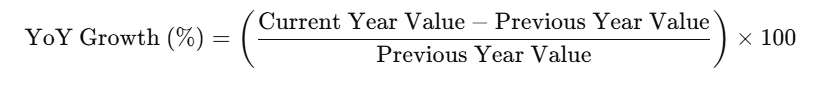

In [343]:
import pandas as pd
import plotly.graph_objects as go

# Ensure datetime format
df_projects['created_at'] = pd.to_datetime(df_projects['created_at'], errors='coerce')

# Extract year and count projects
df_projects['created_year'] = df_projects['created_at'].dt.year
created_year_counts = (
    df_projects['created_year']
    .value_counts()
    .sort_index()
    .reset_index()
)
created_year_counts.columns = ['Year', 'Project Count']

# YoY Growth
created_year_counts['YoY Growth (%)'] = created_year_counts['Project Count'].pct_change().fillna(0) * 100
created_year_counts['YoY Growth (%)'] = created_year_counts['YoY Growth (%)'].round(2)

# Marker color based on growth
created_year_counts['marker_color'] = created_year_counts['YoY Growth (%)'].apply(
    lambda x: 'green' if x >= 0 else 'red'
)

# Hover text
created_year_counts['hover'] = created_year_counts.apply(
    lambda row: f"Year: {row['Year']}<br>Projects: {row['Project Count']}<br>YoY Growth: {row['YoY Growth (%)']}%", axis=1
)

# Plot using plotly.graph_objects
fig = go.Figure()

# Add line trace
fig.add_trace(go.Scatter(
    x=created_year_counts['Year'],
    y=created_year_counts['Project Count'],
    mode='lines',
    line=dict(color='royalblue', width=3),
    name='Project Trend'
))

# Add colored markers
fig.add_trace(go.Scatter(
    x=created_year_counts['Year'],
    y=created_year_counts['Project Count'],
    mode='markers',
    marker=dict(
        size=10,
        color=created_year_counts['marker_color']
    ),
    hovertext=created_year_counts['hover'],
    hoverinfo='text',
    name='Growth Marker'
))

# Annotate peak year
peak_row = created_year_counts.loc[created_year_counts['Project Count'].idxmax()]
fig.add_annotation(
    x=peak_row['Year'],
    y=peak_row['Project Count'],
    text=f"Peak: {peak_row['Project Count']} projects",
    showarrow=True,
    arrowhead=2,
    ax=20,
    ay=-30,
    bgcolor='lightgreen',
    bordercolor='green'
)

# Final layout
fig.update_layout(
    title='Chart 14: Projects Created per Year with YoY Growth Indicators',
    xaxis_title='Year',
    yaxis_title='Project Count',
    xaxis=dict(dtick=1),
    hovermode="x unified"
)

fig.show()


In [344]:
import pandas as pd
import plotly.express as px

# Ensure 'created_at' is datetime
df_projects['created_at'] = pd.to_datetime(df_projects['created_at'], errors='coerce')

# Create month-year datetime column
df_projects['month_year'] = df_projects['created_at'].dt.to_period('M').dt.to_timestamp()

# Count projects per month
monthly_counts = df_projects.groupby('month_year').size().reset_index(name='Project Count')

# Create a full monthly timeline from min to max date
full_range = pd.date_range(start=monthly_counts['month_year'].min(),
                           end=monthly_counts['month_year'].max(),
                           freq='MS')  # MS = Month Start

# Create full DataFrame and merge
full_months_df = pd.DataFrame({'month_year': full_range})
full_months_df = full_months_df.merge(monthly_counts, on='month_year', how='left')
full_months_df['Project Count'] = full_months_df['Project Count'].fillna(0).astype(int)

# Add human-readable labels
full_months_df['Month-Year Label'] = full_months_df['month_year'].dt.strftime('%B %Y')

# Add color column
full_months_df['color'] = full_months_df['Project Count'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot line
fig = px.line(
    full_months_df,
    x='Month-Year Label',
    y='Project Count',
    title='Chart 15: Projects Created by Month and Year',
)

# Add colored points
fig.add_scatter(
    x=full_months_df['Month-Year Label'],
    y=full_months_df['Project Count'],
    mode='markers',
    marker=dict(color=full_months_df['color'], size=10),
    name='Project Count Points',
    showlegend=False
)

fig.update_layout(
    xaxis_title='Month-Year',
    yaxis_title='Project Count',
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


#### Projects Created by Day of the Week

In [345]:
df_projects['weekday'] = df_projects['created_at'].dt.day_name()
weekday_counts = df_projects['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()
weekday_counts.columns = ['Day', 'Project Count']

fig = px.bar(
    weekday_counts,
    x='Day',
    y='Project Count',
    color='Day',
    title='Chart 16: <b>Projects Created by Day of the Week</b>',
    text='Project Count'
)
fig.update_layout(xaxis_title='Day', yaxis_title='Number of Projects', title_x=0.5)
fig.show()


# Section 2 - Analysis Project Milestone and Resources - Data: January 2024 - Present

### Total Effort by Project Category

In [347]:
fig = px.bar(
    df_milestone_resource.groupby('ProjectCategory')['TotalHour'].sum().reset_index(),
    x='ProjectCategory',
    y='TotalHour',
    color='ProjectCategory',
    color_discrete_map=project_category_color_discrete_map,
    title='Chart 18: <b>Total Effort by Project Category</b>',
    text='TotalHour'
)
fig.update_layout(title_x=0.5)
fig.show()


In [348]:
# --- Safe parsing ---
df = df_milestone_resource.copy()

# Make sure TotalHour is numeric
df['TotalHour'] = pd.to_numeric(df['TotalHour'], errors='coerce')

# Normalize ResourceList into a list and explode
def to_list(x):
    if pd.isna(x) or x == '':
        return []
    return [r.strip() for r in str(x).split(',') if r.strip()]

df['ResourceList_norm'] = df['ResourceList'].apply(to_list)
df_exploded = df.explode('ResourceList_norm', ignore_index=True)

In [349]:
import plotly.express as px

# Ensure amount is numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Get top 10 projects by amount
top_projects = df_projects.sort_values('amount', ascending=False).head(10)

# Plot with hover data
fig = px.bar(
    top_projects,
    y='caption',
    x='amount',
    title='Chart 20: Top 10 Projects by Budget',
    color='amount',
    color_continuous_scale='RdYlGn',
    text='amount',
    hover_data=['ref_no'],
    labels={'caption': 'Project Name', 'amount': 'Amount', 'ref_no': 'Reference No'}
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_layout(
    xaxis_title='Amount',
    yaxis_title='Project Name',
    title_x=0.5,
    xaxis_tickangle=45,
    showlegend=False
)

fig.show()


In [350]:
resources_per_milestone = (
    df_exploded.groupby('Milestone')['ResourceList_norm']
      .nunique()  # distinct people per milestone
      .reset_index(name='resource_count')
      .sort_values('resource_count', ascending=False)
)

fig = px.bar(
    resources_per_milestone.head(10),
    x='resource_count',
    y='Milestone',
    color='resource_count' ,
    color_continuous_scale='RdYlGn',
    title='Chart 21: Top 10 Milestones by Unique Resources',
    text='resource_count',
    labels={'resource_count': 'Unique Resources', 'Milestone': 'Milestone Name'}

)
# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_layout(xaxis_tickangle=45, xaxis_title='Milestone', yaxis_title='Unique Resources', showlegend=False)
fig.show()


### Resource Enrollment Analysis

In [351]:
from collections import Counter
import pandas as pd
import plotly.express as px

# Flatten and count resource appearances
resource_series = df_milestone_resource['ResourceList'].dropna().str.split(',')
flat_list = [res.strip() for sublist in resource_series for res in sublist]
resource_counter = Counter(flat_list)

# Top 10
top_10 = pd.DataFrame(resource_counter.most_common(10), columns=['Resource', 'Milestone Count'])

fig1 = px.bar(
    top_10,
    x='Milestone Count',
    y='Resource',
    color='Milestone Count',
    color_continuous_scale='RdYlGn',
    title='Chart 22: <b>Top 10 Most Involved Resources in Milestone</b>',
    text='Milestone Count'
)

# Reverse y-axis so highest budget is on top
fig1.update_yaxes(autorange="reversed")
fig1.update_layout(xaxis_tickangle=45, title_x=0.5)
fig1.show()

# Bottom 10
bottom_10 = pd.DataFrame(sorted(resource_counter.items(), key=lambda x: x[1])[:10],
                         columns=['Resource', 'Milestone Count'])

fig2 = px.bar(
    bottom_10,
    x='Milestone Count',
    y='Resource',
    color='Milestone Count',
    color_continuous_scale='RdYlGn_r',
    title='<b>Bottom 10 Least Involved Resources in Milestone</b>',
    text='Milestone Count'
)
# Reverse y-axis so highest budget is on top
fig2.update_yaxes(autorange="reversed")
fig2.update_layout(xaxis_tickangle=45, title_x=0.5)
fig2.show()


### Milestone Duration Analysis With Projects Name

In [352]:
df_milestone_resource['start_dt'] = pd.to_datetime(df_milestone_resource['start_dt'], errors='coerce')
df_milestone_resource['end_dt'] = pd.to_datetime(df_milestone_resource['end_dt'], errors='coerce')
df_milestone_resource['duration_days'] = (df_milestone_resource['end_dt'] - df_milestone_resource['start_dt']).dt.days

top_longest = df_milestone_resource.sort_values('duration_days', ascending=False).head(10)
fig = px.timeline(top_longest,
                  x_start='start_dt',
                  x_end='end_dt',
                  y='Milestone',
                  title='Chart 23: Long Duration of Milestone',
                  text='duration_days',
                  color_continuous_scale='RdYlGn_r',
                  color='duration_days')
fig.update_yaxes(autorange='reversed')
fig.show(title_x=0.5)



In [353]:
import plotly.express as px

# Sort and get top 10 by TotalHour
top_effort = df_milestone_resource.sort_values('TotalHour', ascending=False).head(10)

# Create horizontal bar chart
fig = px.bar(
    top_effort,
    x='TotalHour',
    y='Milestone',
    color='TotalHour',
    orientation='h',
    color_continuous_scale='RdYlGn',
    title='Chart 24: Top 10 Milestones by Highest Log Hours',
    text='TotalHour',
    hover_data={
        'Project': True,
        'TotalHour': ':.2f',
        'start_dt': '|%Y-%m-%d',
        'end_dt': '|%Y-%m-%d'
    }
)

# Reverse the y-axis to show highest on top
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


In [354]:
import plotly.express as px

# Sort and get bottom 10 by TotalHour
bottom_effort = df_milestone_resource.sort_values('TotalHour', ascending=True).head(10)

# Create horizontal bar chart
fig = px.bar(
    bottom_effort,
    x='TotalHour',
    y='Milestone',
    color='TotalHour',
    orientation='h',
    color_continuous_scale='RdYlGn',
    title='Chart 25: Bottom 10 Milestones by Lowest Log Hours',
    text='TotalHour',
    hover_data={
        'Project': True,
        'TotalHour': ':.2f',
        'start_dt': '|%Y-%m-%d',
        'end_dt': '|%Y-%m-%d'
    }
)

# Keep lowest at bottom
fig.update_layout(
    yaxis=dict(autorange=True),
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


### Monthly Logged Hours Trend

In [355]:
import pandas as pd
import plotly.graph_objects as go

# Prepare data
df = df_milestone_resource.copy()
df['start_dt'] = pd.to_datetime(df['start_dt'], errors='coerce')
df['MonthYear'] = df['start_dt'].dt.to_period('M').dt.to_timestamp()

monthly_effort = df.groupby('MonthYear')['TotalHour'].sum().reset_index()

# Define colors based on condition
monthly_effort['marker_color'] = monthly_effort['TotalHour'].apply(lambda x: 'red' if x == 0 else 'green')

# Plot line first (neutral color)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_effort['MonthYear'],
    y=monthly_effort['TotalHour'],
    mode='lines',
    name='Total Hours',
    line=dict(color='gray', width=2),
    hoverinfo='skip'
))

# Add colored markers
fig.add_trace(go.Scatter(
    x=monthly_effort['MonthYear'],
    y=monthly_effort['TotalHour'],
    mode='markers+text',
    marker=dict(
        size=10,
        color=monthly_effort['marker_color']
    ),
    # text=monthly_effort['TotalHour'].round(1),
    textposition='top center',
    name='Monthly Total Hours',
    hovertemplate='%{x|%b %Y}<br>Total Hours: %{y:,.2f}<extra></extra>'
))

# Layout
fig.update_layout(
    title='Chart 26: Monthly Logged Hours Trend',
    xaxis_title='Month-Year',
    yaxis_title='Total Hours',
    hovermode='x unified',
    xaxis=dict(tickformat='%b %Y'),
    yaxis_tickformat=','
)

fig.show()


# Section 3 - Analysis Log Hour Against Issue

In [356]:
df_log_hour_issue.columns

Index(['EBS_project_name', 'type', 'ProjectCategory', 'amount', 'status',
       'start_dt', 'end_dt', 'go_live_date', 'Milestone', 'work_dt',
       'work_duration', 'Resource', 'user_email', 'team_name', 'issue_details',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')

In [357]:
import plotly.express as px

# Group and sort
project_hours = (
    df_log_hour_issue
    .groupby('EBS_project_name')['work_duration']
    .sum()
    .reset_index()
    # .sort_values('work_duration', ascending=False)
)

# Plot
fig = px.bar(
    project_hours.head(20),
    x='EBS_project_name',
    y='work_duration',
    color='work_duration',
    title='Chart 27: Total Hours Logged per Project',
    color_continuous_scale='RdYlGn',
    text='work_duration'
)

# Format to 2 decimal places
fig.update_traces(
    texttemplate='%{text:.2f}',
    hovertemplate='Project: %{x}<br>Hours: %{y:.2f}<extra></extra>'
)

# Layout
fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


TypeError: unsupported operand type(s) for +: 'datetime.time' and 'datetime.time'

In [ ]:
import pandas as pd
import plotly.express as px

# Ensure issue_details column is valid
df_log_hour_issue['issue_details'] = df_log_hour_issue['issue_details'].fillna('')

# Count issues per project and get top 10
issue_count = (
    df_log_hour_issue
    .groupby('project_name')['issue_details']
    .count()
    .reset_index(name='issue_count')
    .sort_values('issue_count', ascending=False)
    .head(20)
)

# Plot
fig = px.bar(
    issue_count,
    x='project_name',
    y='issue_count',
    color='issue_count',
    title='Chart 28: Number of issues count by project name',
    color_continuous_scale='RdYlGn',
    text='issue_count',
    labels={'project_name': 'Project', 'issue_count': 'Issue Count'}
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Fix data type issue
df_log_hour_issue['hour_spent'] = pd.to_numeric(df_log_hour_issue['hour_spent'], errors='coerce')

# Aggregate
user_hours = (
    df_log_hour_issue
    .groupby('user_email', as_index=False)
    .agg(hour_spent=('hour_spent', 'sum'),
         log_count=('id', 'count'))
    .sort_values('hour_spent', ascending=False)
)

# Top 10
top10 = user_hours.head(20).copy()

# Plot (vertical bars: email on X-axis, hours on Y-axis)
fig = px.bar(
    top10,
    x='user_email',
    y='hour_spent',
    text='hour_spent',
    color='hour_spent',
    color_continuous_scale='RdYlGn',
    title='Chart 29: Top 20 Contributors by Logged Hours (with log count)',
    labels={'hour_spent': 'Hours', 'user_email': 'User'}
)

fig.update_traces(
    texttemplate='%{text:.2f} h',
    hovertemplate=(
        'User: %{x}<br>'
        'Hours: %{y:.2f}<br>'
        'Logs: %{customdata[0]}<extra></extra>'
    ),
    customdata=top10[['log_count']].values
)

# Format layout
fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


### Top 10 Projects by Logged Issues

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Convert to datetime
df_log_hour_issue['updated_at'] = pd.to_datetime(df_log_hour_issue['updated_at'], errors='coerce')

# Step 2: Create Month-Year column
df_log_hour_issue['MonthYear'] = df_log_hour_issue['updated_at'].dt.to_period('M').dt.to_timestamp()

# Step 3: Count issues per month
monthly_issue_updates = (
    df_log_hour_issue
    .groupby('MonthYear')
    .size()
    .reset_index(name='issue_count')
)

# Step 4: Build custom line chart with green markers
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_issue_updates['MonthYear'],
    y=monthly_issue_updates['issue_count'],
    mode='lines+markers',
    marker=dict(
        color='green',
        size=8,
        line=dict(width=1, color='darkgreen')
    ),
    line=dict(color='blue', width=2),
    name='Updated Issues',
    hovertemplate='%{x|%B %Y}<br>Issues: %{y}<extra></extra>'
))

# Step 5: Layout customization
fig.update_layout(
    title='Chart 30: Monthly Timeline of Issue Updates',
    xaxis_title='Month',
    yaxis_title='Number of Issues Updated',
    hovermode='x unified',
    xaxis=dict(tickformat='%b %Y'),
    showlegend=False
)

fig.show()


### Daily Logged Hours Trend

In [ ]:
daily_hours = df_log_hour_issue.groupby('work_dt')['hour_spent'].sum().reset_index()

fig = px.line(
    daily_hours,
    x='work_dt',
    y='hour_spent',
    title='Daily Logged Hours Trend',
    markers=True
)

# Set green color for marker points
fig.update_traces(marker=dict(color='green'))

fig.update_layout(xaxis_title='Work Date', yaxis_title='Hours')
fig.show()
